In [1]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [2]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

In [3]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [4]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [5]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [6]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [7]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [8]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [9]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [10]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [11]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [12]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

In [13]:
import os
import cv2

import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm 

## Decay theory
Input for test:
   * FVC in n week
   * Percent in n week 
   * Age
   * Sex
   * Smoking status
   * CT in n week
   
Result:
   * FVC in any week
   * percent in any week
   
$FVC = a.quantile(0.75) * (week - week_{test}) + FVC_{test}$

$Confidence = Percent + a.quantile(0.75) * abs(week - week_{test}) $

So let's try predict coefficient a. 

In [14]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [15]:
train.SmokingStatus.unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

In [16]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [17]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


## CNN for coeff prediction

In [18]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [19]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [20]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Permute, multiply
import tensorflow.keras.backend as K
from keras.regularizers import l2

def get_model(shape=(512, 512, 1)):
    
    def squeeze_excite_block(in_block, ch, ratio=16):
        x = GlobalAveragePooling2D()(in_block)
        x = Dense(ch//ratio, activation='relu')(x)
        x = Dense(ch, activation='sigmoid')(x)
        return multiply([in_block, x])
    def res_block(x, n_features):
        _x = x
        x = BatchNormalization()(x)
        x = LeakyReLU(0.05)(x)
    
        x = Conv2D(n_features, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        #x = squeeze_excite_block(x, n_features)
        x = Add()([_x, x])
        return x
    
    inp = Input(shape=shape)

    
    # 512
    
    
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.05)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 256
    x = Conv2D(8, kernel_size=(3, 3),  kernel_regularizer=l2(4e-5),strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 8)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 128
    x = Conv2D(16, kernel_size=(3, 3), kernel_regularizer=l2(4e-5),strides=(1, 1), padding='same')(x)
    for _ in range(2):
        x = res_block(x, 16)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 64
    x = Conv2D(32, kernel_size=(3, 3), kernel_regularizer=l2(4e-5),strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 32)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    # 32
    x = Conv2D(64, kernel_size=(3, 3), kernel_regularizer=l2(4e-5),strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 64)
    x = AveragePooling2D(pool_size=(2, 2), strides=(2, 2))(x)    
    
    # 16
    x = Conv2D(128, kernel_size=(3, 3), kernel_regularizer=l2(4e-5),strides=(1, 1), padding='same')(x)
    for _ in range(3):
        x = res_block(x, 128)
        
    # 16
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    #x2 = Dense(1)(x)
    return Model([inp, inp2] , x)

In [21]:
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
from tensorflow_addons.optimizers import RectifiedAdam

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae') 

In [23]:
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P, 
                              shuffle=True, 
                              train_size= 0.8) 

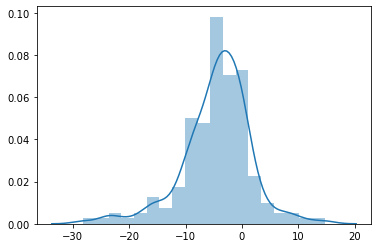

In [24]:
import seaborn as sns

sns.distplot(list(A.values()));

In [25]:
er = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-3,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [26]:
model.fit_generator(IGenerator(keys=tr_p, 
                               a = A, 
                               tab = TAB), 
                    steps_per_epoch = 200,
                    validation_data=IGenerator(keys=vl_p, 
                               a = A, 
                               tab = TAB),
                    validation_steps = 20, 
                    callbacks = [er], 
                    epochs=30)

Epoch 1/30
200/200 [==============================] - 100s 502ms/step - loss: 5.0486 - val_loss: 4.0470
Epoch 2/30
200/200 [==============================] - 81s 407ms/step - loss: 4.6564 - val_loss: 4.4053
Epoch 3/30
200/200 [==============================] - 71s 357ms/step - loss: 4.4362 - val_loss: 4.5535
Epoch 4/30
200/200 [==============================] - 70s 349ms/step - loss: 4.3517 - val_loss: 4.2065
Epoch 5/30
200/200 [==============================] - 68s 341ms/step - loss: 4.3350 - val_loss: 4.4743
Epoch 6/30
200/200 [==============================] - 64s 321ms/step - loss: 4.3761 - val_loss: 4.5938


In [27]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [28]:
from tqdm.notebook import tqdm

metric = []
for q in tqdm(range(1, 10)):
    m = []
    for p in vl_p:
        x = [] 
        tab = [] 
        
        if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
            continue
        for i in os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/'):
            x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
            tab.append(get_tab(train.loc[train.Patient == p, :])) 
        tab = np.array(tab) 
    
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q / 10)
        
        percent_true = train.Percent.values[train.Patient == p]
        fvc_true = train.FVC.values[train.Patient == p]
        weeks_true = train.Weeks.values[train.Patient == p]
        
        fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
        percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
        m.append(score(fvc_true, fvc, percent))
    print(np.mean(m))
    metric.append(np.mean(m))

6.704066890350748
6.704134255832129
6.704288822252905
6.704470595891954
6.704635247930737
6.70468181042047
6.705507445898948
6.706140805154046
6.706490976080671



## Predict

In [29]:
q = (np.argmin(metric) + 1)/ 10
q

0.1

In [30]:
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
sub.head() 

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [31]:
test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [32]:
A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
STD, WEEK = {}, {} 
for p in test.Patient.unique():
    x = [] 
    tab = [] 
    for i in os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/'):
        x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
        tab.append(get_tab(test.loc[test.Patient == p, :])) 
    tab = np.array(tab) 
            
    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]

In [33]:
for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 
    
    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 
    

In [34]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3084.275334,134.462189
1,ID00421637202311550012437_-12,2831.912261,174.957553
2,ID00422637202311677017371_-12,1992.817006,139.489500
3,ID00423637202312137826377_-12,3394.098544,179.357447
4,ID00426637202313170790466_-12,2963.095687,109.920655


In [35]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [36]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

In [37]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [38]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [39]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [40]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [41]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [42]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [43]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [44]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
#data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','week','BASE']

In [45]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [46]:
tr.shape, chunk.shape, sub.shape

((1535, 21), (5, 21), (730, 21))

In [47]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Nadam

from keras import backend as K

In [48]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

In [49]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [50]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [51]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          900         Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [52]:
NFOLD = 2 # originally 5
kf = KFold(n_splits=NFOLD)

In [53]:
%%time
cnt = 0
EPOCHS = 600
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
train [45.792118072509766, 6.618127822875977]
val [57.64976501464844, 6.820955276489258]
predict val...
predict test...
FOLD 2
train [49.73469543457031, 6.634220600128174]
val [49.72467803955078, 6.664309024810791]
predict val...
predict test...
CPU times: user 1min, sys: 3.91 s, total: 1min 3s
Wall time: 54.8 s


In [54]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

155.56214456465034 264.10074610011196


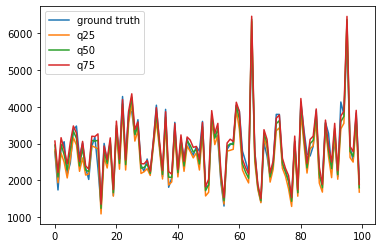

In [55]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [56]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

21.475341796875 264.10074610011196 494.991455078125 1.0


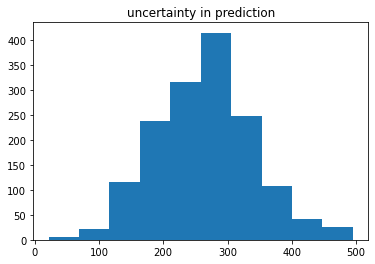

In [57]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [58]:
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull()].head(10)

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,3020.889893,200.388428
1541,ID00419637202311204720264_-11,3020,100.0,3017.152344,203.031860
1542,ID00419637202311204720264_-10,3020,100.0,3013.414673,205.675049
1543,ID00419637202311204720264_-9,3020,100.0,3009.677246,208.318115
1544,ID00419637202311204720264_-8,3020,100.0,3005.939697,210.961182
1545,ID00419637202311204720264_-7,3020,100.0,3002.202148,213.604614
1546,ID00419637202311204720264_-6,3020,100.0,2998.464844,216.247925
1547,ID00419637202311204720264_-5,3020,100.0,2994.727051,218.890869
1548,ID00419637202311204720264_-4,3020,100.0,2990.989624,221.534302
1549,ID00419637202311204720264_-3,3020,100.0,2987.256958,224.176758


In [59]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
sigma_mean = 60
if sigma_mean<sigma_mean:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [60]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020.889893,200.388428,3020.889893,200.388428
1541,ID00419637202311204720264_-11,3017.152344,203.031860,3017.152344,203.031860
1542,ID00419637202311204720264_-10,3013.414673,205.675049,3013.414673,205.675049
1543,ID00419637202311204720264_-9,3009.677246,208.318115,3009.677246,208.318115
1544,ID00419637202311204720264_-8,3005.939697,210.961182,3005.939697,210.961182


In [61]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2586.564960,423.627717,1714.916565,2449.447144,2656.450867,2878.342987,3333.343872
Confidence,730.0,325.703417,71.606279,175.553345,276.396606,326.479309,390.631500,445.628662
FVC1,730.0,2586.564960,423.627717,1714.916565,2449.447144,2656.450867,2878.342987,3333.343872
Confidence1,730.0,325.703417,71.606279,175.553345,276.396606,326.479309,390.631500,445.628662


In [62]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [63]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [64]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

In [65]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [66]:
df = df1[['Patient_Week']].copy()
df['FVC'] = (0.4*df1['FVC'] + 0.6*df2['FVC'])
df['Confidence'] = (0.4*df1['Confidence'] + 0.6*df2['Confidence'])
df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,3005.903170,175.745002
1,ID00419637202311204720264_-10,3038.902256,174.333223
2,ID00419637202311204720264_-11,3042.573199,174.175651
3,ID00419637202311204720264_-12,3046.244069,174.017932
4,ID00419637202311204720264_-2,3009.556243,175.590506


In [67]:
df.to_csv('submission.csv', index=False)